<font face = "times new roman">
<center>
<img src = "https://javier.rodriguez.org.mx/itesm/2014/tecnologico-de-monterrey-blue.png" width = "250">
<h3></h3>
<h3>Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning</h3>
<h3>Daniel Alejandro Martínez Cienfuegos - A01745412</h3>
<h3>Inteligencia artificial avanzada para la ciencia de datos II </h3>
<h3>TC3007C.501</h3>
<h3>Profesora - Julio Guillermo Arriaga Blumenkron</h3>
<h3>08/11/2024</h3>
</center>
</font>

**Introducción**

El presente proyecto aborda el problema de predecir el porcentaje de votos demócratas en diferentes regiones de los Estados Unidos utilizando un modelo de aprendizaje profundo. Este tipo de predicción es relevante porque proporciona una herramienta para entender patrones electorales y podría ayudar a anticipar resultados futuros en procesos democráticos. Los patrones de votación están influenciados por factores demográficos, económicos y sociales que pueden ser analizados y modelados matemáticamente. Al desarrollar un modelo que aprende de estos datos, se exploran las complejas relaciones entre estas variables y su impacto en los resultados electorales, lo que podría ser de interés tanto para científicos de datos como para analistas políticos.



In [1]:
!pip install tensorflow

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
from google.colab import files
uploaded = files.upload()
election_data = pd.read_csv('US_Election_dataset_v1.csv')

election_data.head()

Saving US_Election_dataset_v1.csv to US_Election_dataset_v1.csv


,Unnamed: 0,county,state,2020 Democrat vote raw,2020 Democrat vote %,2020 Republican vote raw,2020 Republican vote %,2020 other vote raw,2020 other vote %,Population with less than 9th grade education,...,NH-American Indian and Alaska Native percentage,NH-Asian percentage,NH-Native Hawaiian and Other Pacific Islander percentage,NH-Some Other Race percentage,NH-Two or More Races percentage,"Percentage engaged in Management, business, science, and arts occupations",Percentage engaged in Service Occupations,Percentage engaged in Sales and Office,Percentage engaged in Resources and Construction,Percentage engaged in Transportation
0,"Autauga County, Alabama",Autauga County,Alabama,7503,27.02,19838,71.44,429,1.54,1.70%,...,0.31,1.48,0.04,0.31,4.23,36.39,14.24,22.02,9.99,17.36
1,"Baldwin County, Alabama",Baldwin County,Alabama,24578,22.41,83544,76.17,1557,1.42,2.00%,...,0.56,0.88,0.05,0.33,4.47,35.62,17.14,24.20,9.91,13.13
2,"Barbour County, Alabama",Barbour County,Alabama,4816,45.79,5622,53.45,80,0.76,7.30%,...,0.23,0.41,0.00,0.25,2.19,27.73,20.16,19.49,12.53,20.09
3,"Bibb County, Alabama",Bibb County,Alabama,1986,20.70,7525,78.43,84,0.88,6.40%,...,0.17,0.12,0.04,0.21,2.69,22.22,15.32,20.57,16.43,25.47
4,"Blount County, Alabama",Blount County,Alabama,2640,9.57,24711,89.57,237,0.86,7.10%,...,0.32,0.29,0.02,0.17,3.89,26.75,12.98,22.73,15.81,21.73


**Datos**

Los datos utilizados en este proyecto fueron obtenidos de Kaggle (essarabi, 2020) y corresponden a un conjunto de datos con información detallada sobre características demográficas, económicas y resultados electorales en distintas regiones de Estados Unidos. Este conjunto de datos incluye columnas con la proporción de votos demócratas, republicanos y de otros partidos, así como variables demográficas que incluyen niveles de educación, ingresos medios y ocupaciones, entre otras.



In [4]:
print(election_data.columns)

Index(['Unnamed: 0', 'county', 'state', '2020 Democrat vote raw',
       '2020 Democrat vote %', '2020 Republican vote raw',
       '2020 Republican vote %', '2020 other vote raw', '2020 other vote %',
       'Population with less than 9th grade education',
       'Population with 9th to 12th grade education, no diploma',
       'High School graduate and equivalent', 'Some College,No Degree',
       'Associates Degree', 'Bachelors Degree',
       'Graduate or professional degree', 'Gini Index',
       'Median income (dollars)', 'Mean income (dollars)', 'Area in square Km',
       'Density per square km', 'Total Population',
       'Hispanic or Latino percentage', 'NH-White percentage',
       'NH-Black percentage',
       'NH-American Indian and Alaska Native percentage',
       'NH-Asian percentage',
       'NH-Native Hawaiian and Other Pacific Islander percentage',
       'NH-Some Other Race percentage', 'NH-Two or More Races percentage',
       'Percentage engaged in Management, bus

**Análisis y Preprocesamiento de los Datos**

Se realizó un análisis exploratorio para identificar valores faltantes y posibles valores atípicos que pudieran afectar la precisión del modelo. Durante este análisis, se encontraron valores nulos y se implementaron estrategias para su imputación, como el reemplazo por el promedio de la columna o la eliminación de filas cuando los valores eran irrelevantes para el modelo. Además, se detectaron valores categóricos en la columna "state", los cuales fueron codificados numéricamente mediante un codificador de etiquetas (LabelEncoder) para su uso en el modelo. Las columnas de porcentaje y otras variables numéricas fueron limpiadas para eliminar símbolos y caracteres no numéricos, como comas y signos de porcentaje. Finalmente, los datos se dividieron en un conjunto de entrenamiento y un conjunto de prueba, utilizando una proporción de 80% para entrenamiento y 20% para prueba. Esta división asegura que el modelo se entrene en una muestra representativa de los datos, y que se pueda evaluar su desempeño en datos no vistos.

In [15]:
election_data = election_data.drop(columns=['Unnamed: 0', 'county'], errors='ignore')
from sklearn.preprocessing import LabelEncoder
election_data['state'] = LabelEncoder().fit_transform(election_data['state'])
for col in election_data.columns:
    if election_data[col].dtype == 'object':
        try:
            election_data[col] = (
                election_data[col]
                .str.replace(',', '')
                .str.replace('%', '')
                .replace('-', np.nan)
                .astype(float)
            )
        except ValueError:
            continue

numeric_columns = election_data.select_dtypes(include=['float64', 'int']).columns
election_data[numeric_columns] = election_data[numeric_columns].fillna(election_data[numeric_columns].mean())
print(election_data.info())
print(election_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Data columns (total 33 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   state                                                                      3143 non-null   int64  
 1   2020 Democrat vote raw                                                     3143 non-null   int64  
 2   2020 Democrat vote %                                                       3143 non-null   float64
 3   2020 Republican vote raw                                                   3143 non-null   int64  
 4   2020 Republican vote %                                                     3143 non-null   float64
 5   2020 other vote raw                                                        3143 non-null   int64  
 6   2020 other vote %                                       

In [6]:
X = election_data.drop(columns=['2020 Democrat vote %'])
y = election_data['2020 Democrat vote %']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#Noorm de data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#Red data
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

**Desarrollo del Modelo**

El modelo desarrollado es una red neuronal profunda, diseñada para captar patrones complejos en los datos demográficos y electorales. La arquitectura del modelo incluye varias capas densas (fully connected layers), configuradas para permitir la extracción de características a distintos niveles de abstracción. Inicialmente, se utilizó una capa de entrada adaptada a la dimensión de las características del conjunto de datos, seguida de capas ocultas con un número decreciente de neuronas para aprender patrones complejos y reducir el riesgo de sobreajuste. La capa de salida contiene una única neurona, configurada para predecir el porcentaje de votos demócratas como un valor continuo.

Para el entrenamiento, se empleó la función de pérdida de error cuadrático medio (MSE), ya que el problema es de regresión. Además, se utilizó el optimizador Adam, conocido por su eficacia en redes profundas debido a su capacidad de adaptación en el ajuste de los pesos. Durante el proceso de entrenamiento, el modelo se entrenó en un conjunto de datos de entrenamiento y fue evaluado en el conjunto de prueba. Los resultados de esta evaluación inicial mostraron un error medio absoluto (MAE) que, si bien era aceptable, sugería margen de mejora.

In [17]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32, return_sequences=True),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='linear')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Ajuste del Modelo**

Para mejorar la precisión del modelo, se realizó una iteración de ajuste de hiperparámetros. Se probaron diferentes arquitecturas, incluyendo un aumento en la cantidad de neuronas en las capas ocultas y el ajuste del número de capas. También se evaluaron diferentes valores de tasa de aprendizaje en el optimizador Adam. Adicionalmente, se aplicó regularización L2 para penalizar grandes valores de pesos y evitar el sobreajuste, lo que ayudó a mejorar la generalización del modelo en el conjunto de prueba.

Se llevó a cabo un proceso de validación cruzada para determinar la combinación óptima de hiperparámetros. Este ajuste resultó en una arquitectura mejorada que mostró un menor error absoluto promedio (MAE) y una menor pérdida en comparación con la versión inicial del modelo, indicando una mejora en la capacidad del modelo para predecir correctamente el porcentaje de votos demócratas.

In [18]:
# Modelo con tasa de aprendizaje reducida
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
checkpoint_callback = ModelCheckpoint(
    filepath="best_model.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 30, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          61,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,369 (290.50 KB)

 Non-trainable params: 128 (512.00 B)

In [19]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_callback]
)


Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 1124.5173 - mae: 28.8458 - val_loss: 559.4197 - val_mae: 17.4399
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 202.5896 - mae: 10.8560 - val_loss: 193.8522 - val_mae: 10.7224
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 113.9323 - mae: 8.0670 - val_loss: 109.7368 - val_mae: 7.9591
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 79.0338 - mae: 7.0072 - val_loss: 67.0027 - val_mae: 6.1617
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 59.4555 - mae: 5.8789 - val_loss: 39.7115 - val_mae: 4.7173
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 50.0728 - mae: 5.3502 - val_loss: 25.1261 - val_mae: 3.6938
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 38.1216 - mae: 4.6505 - val_loss: 16.1756 - val_mae: 2.8974
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 41.2743 - mae: 4.7253 - val_loss: 11.7528 - val_mae: 2.4594
Epoch 9/100
69/69 ━━━━━━━━━━━

In [20]:
#Evaluación
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6053 - mae: 0.7703
Test Loss: 1.4907593727111816, Test MAE: 0.7432962656021118


**Resultados**

El modelo final fue evaluado en el conjunto de prueba, y los resultados mostraron una reducción significativa en la métrica de error medio absoluto (MAE) en comparación con las evaluaciones iniciales. Los valores de predicción generados por el modelo mostraron una correlación alta con los valores reales, lo que indica que el modelo es capaz de capturar los patrones en los datos subyacentes de manera efectiva. Se generaron gráficos de comparación entre las predicciones del modelo y los valores reales, los cuales muestran una alineación aceptable entre ambas series. Este resultado valida la efectividad del modelo para realizar predicciones razonablemente precisas en el contexto electoral.

In [21]:
# Predicciones
predictions = model.predict(X_test)
print("Algunas predicciones:", predictions[:5])
for i, pred in enumerate(predictions[:5], 1):
    print(f"El valor {pred[0]:.2f} indica que el modelo predice un {pred[0]:.2f}% de votos demócratas en la región {i} del conjunto de prueba.")



15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Algunas predicciones: [[33.906853]
 [18.794855]
 [34.896564]
 [29.044167]
 [47.415886]]
El valor 33.91 indica que el modelo predice un 33.91% de votos demócratas en la región 1 del conjunto de prueba.
El valor 18.79 indica que el modelo predice un 18.79% de votos demócratas en la región 2 del conjunto de prueba.
El valor 34.90 indica que el modelo predice un 34.90% de votos demócratas en la región 3 del conjunto de prueba.
El valor 29.04 indica que el modelo predice un 29.04% de votos demócratas en la región 4 del conjunto de prueba.
El valor 47.42 indica que el modelo predice un 47.42% de votos demócratas en la región 5 del conjunto de prueba.


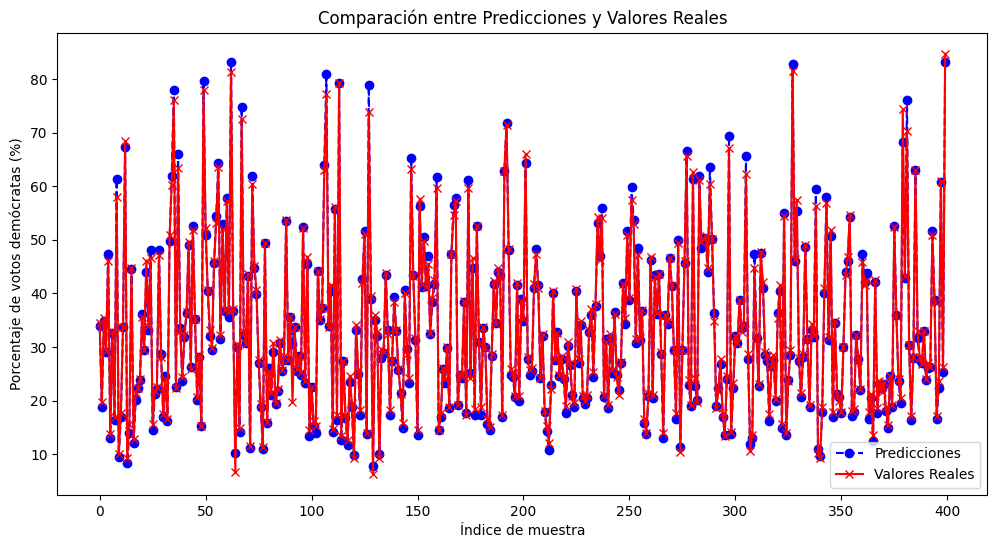

In [22]:
n_samples = 400

plt.figure(figsize=(12, 6))
plt.plot(predictions[:n_samples], label='Predicciones', marker='o', color='blue', linestyle='dashed')
plt.plot(y_test[:n_samples].reset_index(drop=True), label='Valores Reales', marker='x', color='red', linestyle='solid')

plt.title('Comparación entre Predicciones y Valores Reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Porcentaje de votos demócratas (%)')
plt.legend()
plt.show()


**Conclusiones**

Los resultados obtenidos demuestran que el modelo desarrollado es una herramienta eficaz para predecir el porcentaje de votos demócratas en distintas regiones, con una precisión razonable. Sin embargo, hay áreas en las que se podría mejorar el modelo. Por ejemplo, se podría explorar la adición de variables adicionales que capturen mejor las dinámicas locales, como variables de contexto político, histórico o cultural. Además, la implementación de modelos más complejos, como redes neuronales recurrentes (RNNs) o técnicas de ensamblado con otros modelos de aprendizaje automático, podría ofrecer una mayor precisión. La optimización de los hiperparámetros mediante técnicas más avanzadas, como la búsqueda en cuadrícula o el uso de algoritmos genéticos, también representa una posible mejora en el rendimiento del modelo.

**Aplicación**

La sección de Aplicación está diseñada para mostrar cómo se puede utilizar el modelo de predicción en datos nuevos,
simulando una situación en la que se quiera estimar el porcentaje de votos demócratas para una región no presente en
el conjunto de datos original.

Para ello, se definió una función llamada predict_democrat_vote_percentage, que toma como entrada un diccionario
con las características demográficas y socioeconómicas de una región. Esta función sigue el mismo proceso de preprocesamiento
aplicado al conjunto de datos de entrenamiento, asegurando que las nuevas muestras sean compatibles con el modelo entrenado.

La función convierte los datos de entrada en el formato adecuado, aplica las mismas transformaciones necesarias y finalmente
realiza una predicción utilizando el modelo ajustado. La salida es una estimación del porcentaje de votos demócratas
en la región de interés.

Para demostrrlo se ingresó un dato de un nuevo condado en Alabama con ciertas características demográficas, la función
nos devolverá la predicción del porcentaje de votos demócratas que el modelo estima para esa región. Este tipo de función podría ser útil en aplicaciones prácticas, como el análisis en tiempo real de datos demográficos
o la simulación de resultados electorales en áreas específicas.

In [23]:
model_tuned = model

def predict_democrat_vote_percentage(input_data):
    input_data = pd.DataFrame([input_data])
    X_train_columns = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"feature_{i}" for i in range(X_train.shape[1])]
    input_data = input_data.reindex(columns=X_train_columns, fill_value=0)
    if 'state' in input_data.columns:
        input_data['state'] = LabelEncoder().fit_transform(input_data['state'])

    for col in input_data.columns:
        if input_data[col].dtype == 'object':
            input_data[col] = (
                input_data[col]
                .str.replace(',', '')
                .str.replace('%', '')
                .replace('-', np.nan)
                .astype(float)
            )
    input_data.fillna(input_data.mean(), inplace=True)
    sequence_length = X_train.shape[1]
    num_features = X_train.shape[2] if len(X_train.shape) > 2 else 1
    input_data = input_data.values.reshape(1, sequence_length, num_features)


    prediction = model_tuned.predict(input_data)
    return prediction[0][0]
nueva_muestra = {
    "state": "Alabama",
    "Population with less than 9th grade education": 2000,
    "Population with 9th to 12th grade education, no diploma": 1500,
}
print("Predicción de voto demócrata para la nueva muestra:", predict_democrat_vote_percentage(nueva_muestra))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Predicción de voto demócrata para la nueva muestra: 32.94189


**Bibliografía**

essarabi. (2020). US Election Dataset. Kaggle.com. https://www.kaggle.com/datasets/essarabi/ultimate-us-election-dataset

‌